# Regression benchmark—rotating MNIST

In [1]:
import os
import re
import jax
import optax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from time import time
from rebayes.sgd_filter import replay_sgd as rsgd

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [3]:
import flax.linen as nn

In [4]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
def load_output(filename, path):
    filename = os.path.join(path, filename)
    with open(filename, "rb") as f:
        res = pickle.load(f) 
    return res

In [14]:
from rebayes.utils.utils import get_subtree, tree_to_cpu

In [15]:
def tree_shape(tree):
    return jax.tree_map(jnp.shape, tree)

In [16]:
# base_path = "./output/sorted-rotating-mnist/"
base_path = "./output/sorted-rotated-mnist-v2"
base_path = "./output/rotated-mnist/"

In [17]:
dataset_name = "rotating-mnist-2-mlp"
# dataset_name = "sorted-rotating-mnist-2-mlp"

filenames = os.listdir(base_path)
# filenames = [file for file in filenames if (dataset_name in file)]

In [18]:
regexp = re.compile(rf"{dataset_name}-(\w+)")
agents = [regexp.search(filename)[1] for filename in filenames]

In [19]:
agents_output = {}
agents_res = {}
for i, (agent_name, filename) in enumerate(zip(agents, filenames)):
    res = load_output(filename, base_path)
    agent_name = f"{agent_name}"
    agents_output[agent_name] = res["output"]
    agents_res[agent_name] = res

In [20]:
colors = plt.cm.tab10(np.linspace(0, 1, len(agents) + 1))
colors = plt.cm.tab10(np.arange(len(agents) + 1))
colors = {
    name_agent: color
    for name_agent, color
    in zip(agents + ["sgd-rb"], colors)
}

In [21]:
data = get_subtree(agents_output, "test")
data = tree_to_cpu(data)

data = pd.DataFrame(data)
data.index.name = "n_obs"
data = data.reset_index()
data = data.melt(id_vars="n_obs", var_name="model", value_name="rmse")

In [22]:
models = data["model"]
model_desc = models.str.split("rank(?P<rank>[0-9]+)_", regex=True, expand=True).drop(0, axis=1)
model_desc.columns = ["rank", "agent"]
model_desc["rank"] = model_desc["rank"].astype(int)

data = data.join(model_desc)
data.tail()

,n_obs,model,rmse,rank,agent
184995,4995,rank50_vdekf,47.201141,50,vdekf
184996,4996,rank50_vdekf,47.200760,50,vdekf
184997,4997,rank50_vdekf,47.200409,50,vdekf
184998,4998,rank50_vdekf,47.200531,50,vdekf
184999,4999,rank50_vdekf,47.200184,50,vdekf


In [23]:
agents = data.agent.unique()
agents

array(['fdekf', 'lofi', 'orfit', 'sgd', 'vdekf'], dtype=object)

In [1]:
agents_void = ["lofi_diag", "lofi_orth", "vdekf"]

In [2]:
data = data.query("agent not in @agents_void")

NameError: name 'data' is not defined

In [ ]:
n_obs = data["n_obs"].max()

### Data analysis

In [3]:
dataset_name = "sorted-rotating-mnist-2-mlp"

In [4]:
sorted([key for key in agents_res if "lofi" in key])

NameError: name 'agents_res' is not defined

In [30]:
summary = data.query("n_obs==@n_obs").pivot_table(index="rank", columns="agent", values="rmse")
summary

agent,fdekf,lofi,orfit,sgd,vdekf
rank,,,,,
2,16.132053,16.285477,16.645508,15.846716,46.520481
5,16.132055,17.269554,16.808962,13.705531,46.520473
10,16.132055,18.573122,17.095413,13.409840,46.520473
20,16.132055,18.349148,16.498913,12.562925,47.200184
50,16.132055,18.265636,16.391811,12.198833,47.200184
100,16.132055,47.712017,16.157454,11.333379,47.200184
150,16.132055,47.712017,15.135195,11.431115,47.200184
200,16.132055,NaN,NaN,NaN,47.200184


In [33]:
hparam_table = []
for key in agents_res:
    if "lofi" in key:
        entry = {
            **agents_res[key]["hparams"]["params"],
            "rank": int(key.lstrip("rank").rstrip("_lofi"))
        }
        hparam_table.append(entry)
    
hparam_table = pd.DataFrame(hparam_table).set_index("rank").sort_index()

In [34]:
hparam_table.join(summary["lofi"])

,dynamics_weights,log_emission_cov,log_init_cov,lofi
rank,,,,
2,1.0,-5.300343,-6.514733,16.285477
5,1.0,-1.313806,-5.546954,17.269554
10,1.0,-1.140309,-6.058475,18.573122
20,1.0,-1.138937,-6.055404,18.349148
50,1.0,-1.134895,-6.043282,18.265636
100,1.0,-2.794198,-25.150288,47.712017
150,1.0,-2.391342,-26.189568,47.712017


## One-step-ahed

Text(0.5, 0, 'agent memory')

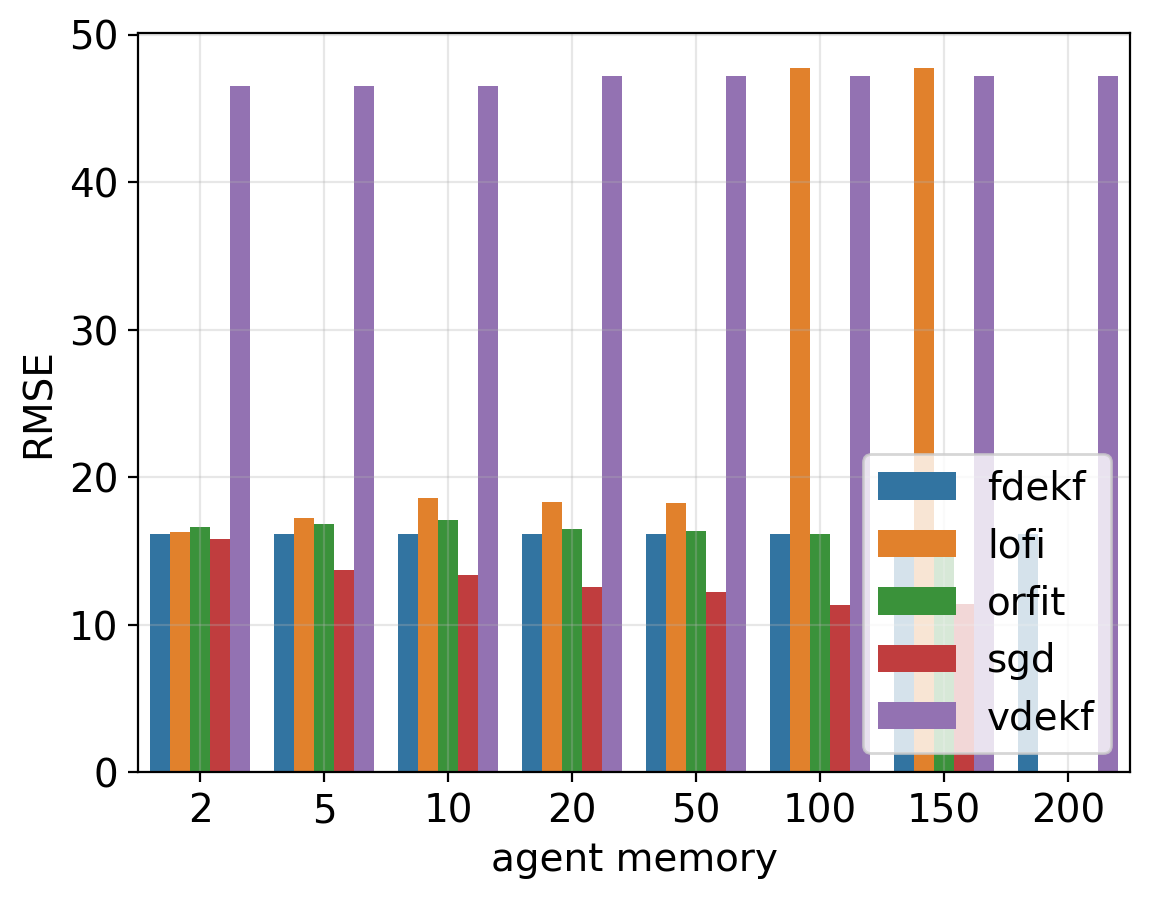

In [35]:
sns.barplot(x="rank", y="rmse", hue="agent", data=data.query("n_obs == @n_obs"))
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.ylabel("RMSE")
plt.xlabel("agent memory")
# plt.savefig(f"output/images/{dataset_name}-final-test-rmse.pdf")

In [36]:
agents = list(data["agent"].unique())
cmap = plt.cm.tab10
colors = {
    agent: cmap(i)
    for i, agent in enumerate(agents)
}

In [37]:
rank_unique = data["rank"].unique()

Text(0, 0.5, 'RMSE')

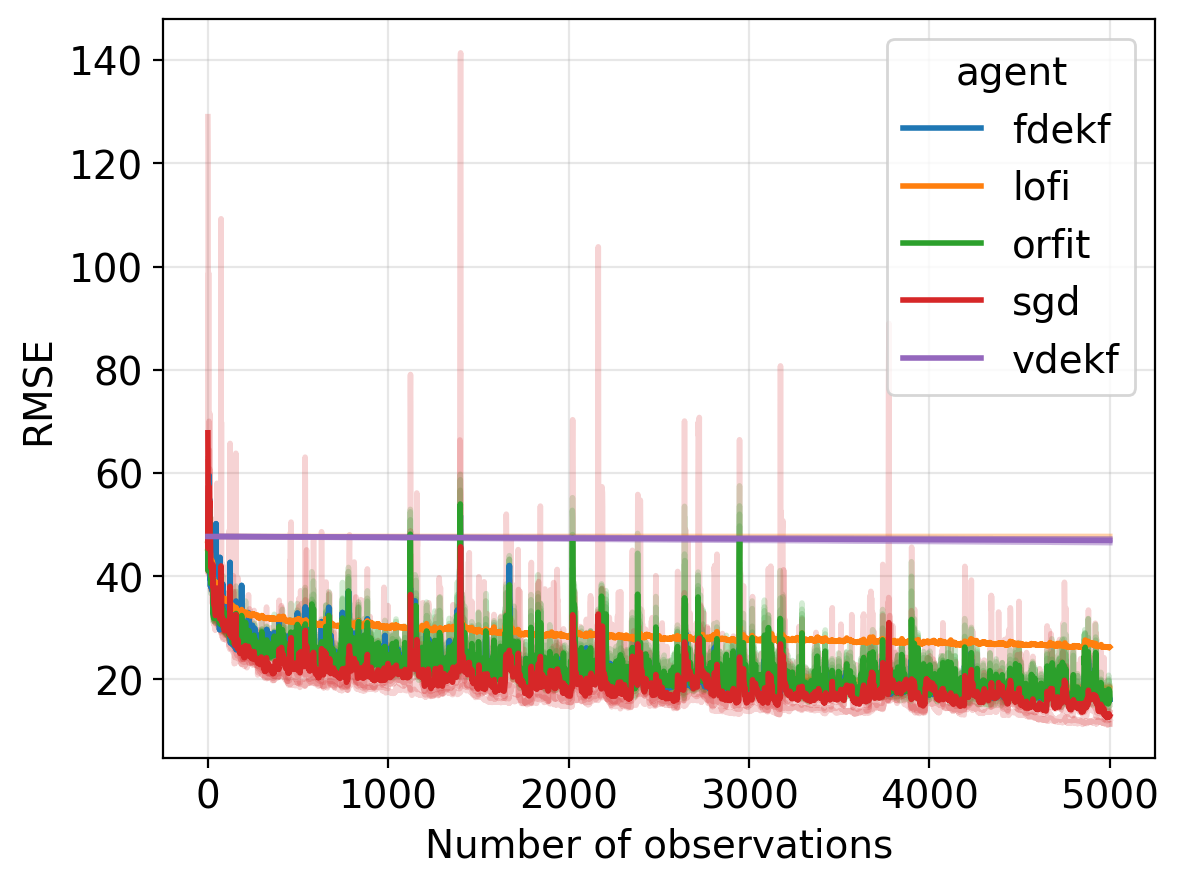

In [39]:
fig, ax = plt.subplots()
for rank in rank_unique:
    data.query("rank == @rank").pivot_table(index="n_obs", columns="agent", values="rmse").plot(legend=False, alpha=0.2, ax=ax, color=colors)
    
data.pivot_table(index="n_obs", columns="agent", values="rmse").plot(ax=ax, color=colors)
# ax.set_ylim(40, 100)
ax.grid(alpha=0.3)
ax.set_xlabel("Number of observations")
ax.set_ylabel("RMSE")
# plt.savefig(f"output/images/{dataset_name}-hist-test-rmse.pdf")